In [8]:
# Step 1: Create a custom dataset class.
# This step does the following:
# Open image in PIL format, convert to RGB, and apply basic transform/toTensor.
# Extract bbox, labels based on the class map.
# If an image has no car, handle it gracefully.
# Return image & target.

import os
import torch
import torchvision
from PIL import Image
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader
import numpy as np

class KITTIDataset(Dataset):
    def __init__(self, image_dir, label_dir, transforms=None, verbose=True):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transforms = transforms
        self.verbose = verbose
        self.image_files = sorted(os.listdir(image_dir))

    def __getitem__(self, idx): # Retrieves image-label pair at index
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        label_path = os.path.join(self.label_dir, img_name.replace('.png', '.txt'))

        # Load image
        img = Image.open(img_path).convert("RGB")
        img = self.transforms(img) if self.transforms else ToTensor()(img)

        # Try loading annotations
        boxes = []
        labels = []

        if not os.path.exists(label_path):
            if self.verbose:
                print(f"[Warning] Label file not found for image: {img_name}. Skipping annotations.")
        else:
            with open(label_path) as f:
                for line in f:
                    fields = line.strip().split()
                    if len(fields) < 8: # class, truncation, occlusion, alpha, x1, y1, x2, y2 (bbox)
                        continue  # Skip malformed lines
                    cls = fields[0].lower()
                    if cls == "dontcare":
                        continue
                    if cls != "car":
                        continue
                    xmin, ymin, xmax, ymax = map(float, fields[4:8])
                    boxes.append([xmin, ymin, xmax, ymax])
                    labels.append(1)  # class ID for 'Car'

        # Handle images with no valid boxes
        if len(boxes) == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
        else:
            boxes = torch.tensor(boxes, dtype=torch.float32)
            labels = torch.tensor(labels, dtype=torch.int64)

        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': idx, # torch.tensor([idx]),tensor needed for training,.item() is called internally, idx for inference (only needs image)
            'area': (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]), # for validation
            'iscrowd': torch.zeros((len(labels),), dtype=torch.int64), # for validation

        }
        return img, target

    def __len__(self):
        return len(self.image_files)


In [9]:
# Step 2: Update collate function
# Faster R-CNN expects lists of targets, not a stacked tensor (PyTorch defaut).
def collate_fn(batch):
    return tuple(zip(*batch)) # tuple of images ->(img1, img2, ...),  tuple of targets -> (target1, target2, ...)

#def collate_fn(batch):
#    return list(zip(*batch)) # For readability


In [10]:
# Step 3: Split train/val (80/20) randomly & save them for reproducibility
import random
all_images = sorted(os.listdir('/content/drive/MyDrive/faster r-cnn/train/images'))
random.seed(42)
random.shuffle(all_images)

train_images = all_images[:800]
val_images = all_images[800:1000]

#split_idx = int(0.8 * len(all_images)) # Dynamic percentage-based splitting for larger datasets
#train_images = all_images[:split_idx]
#val_images = all_images[split_idx:]

# Sanity check: ensure no overlap between train and val sets
assert set(train_images).isdisjoint(set(val_images)), "Train/Val sets overlap!"

# Save these to text files for reproducibility
with open('train.txt', 'w') as f:
    f.write('\n'.join(train_images))
with open('val.txt', 'w') as f:
    f.write('\n'.join(val_images))

In [11]:
# Step 4: Subclass FilteredKITTIDataset of KITTIDataset
# This filters images based on image filenames in train.txt, val.txt

class FilteredKITTIDataset(KITTIDataset):
    def __init__(self, image_dir, label_dir, image_list_file, transforms=None):
        super().__init__(image_dir, label_dir, transforms)

        # Load selected image filenames from train.txt or val.txt
        with open(image_list_file) as f:
            selected = set(f.read().splitlines())

        # Filter image_files based on the selection
        self.image_files = [f for f in self.image_files if f in selected]

        # Safety check to catch mistakes early
        assert len(self.image_files) > 0, f"No matching images found in {image_list_file}"


In [12]:
# Step 5: Create dataset & dataloader for train & val

train_dataset = FilteredKITTIDataset(
    '/content/drive/MyDrive/faster r-cnn/train/images',
    '/content/drive/MyDrive/faster r-cnn/train/labels',
    'train.txt',
    #transforms = None
)

val_dataset = FilteredKITTIDataset(
    '/content/drive/MyDrive/faster r-cnn/train/images',
    '/content/drive/MyDrive/faster r-cnn/train/labels',
    'val.txt'
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)


In [6]:
# Step 6: Load model, set number of classes, & change the layer accordingly
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import torchvision
import torch
import torch.optim as optim

# Load pre-trained Faster R-CNN
model = fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 2  # 1 class ('Car') + background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

# Move model to GPU or CPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Set optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# Learning rate scheduler
from torch.optim.lr_scheduler import StepLR
lr_scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

# Training loop with best model saving
best_val_loss = float('inf')
best_model_path = "fasterrcnn_best1.pth"
num_epochs = 40

for epoch in range(num_epochs):
    # --- Training ---
    model.train() # Input: images + targets, Output: loss_dict for torchvision
    train_loss = 0.0
    # Initialize at start of epoch
    loss_comp_sum = {
        'loss_classifier': 0.0,
        'loss_box_reg': 0.0,
        'loss_objectness': 0.0,
        'loss_rpn_box_reg': 0.0
    }
    for imgs, targets in train_loader:
        imgs = [img.to(device) for img in imgs]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(imgs, targets)
        losses = sum(loss for loss in loss_dict.values())
        for k in loss_dict:
            loss_comp_sum[k] += loss_dict[k].item()
        #for k, v in loss_dict.items():
          #  print(f"Epoch [{epoch+1}] - {k}: {v.item():.4f}") # losses like loss_classifier + loss_box_reg + loss_objectness + loss_rpn_box_reg

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        train_loss += losses.item()

    avg_train_loss = train_loss / len(train_loader)

    # --- Validation ---
    # model.eval() # Input: images only (targets = None) Output: predictions
    model.train()  # NOTE: Needed to compute loss in torchvision models, switch back to train mode to compute loss
    val_loss = 0.0
    with torch.no_grad():
        for imgs, targets in val_loader:
            imgs = [img.to(device) for img in imgs]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(imgs, targets)
            losses = sum(loss for loss in loss_dict.values())
            val_loss += losses.item()
    model.eval()  # return to eval mode after validation for safety and good practice.

    avg_val_loss = val_loss / len(val_loader)

    # Update the learning rate
    lr_scheduler.step()
    print(f"Current LR: {optimizer.param_groups[0]['lr']:.6f}")

    # After epoch loop
    num_batches = len(train_loader)
    for k in loss_comp_sum:
        print(f"Epoch [{epoch+1}] - Avg {k}: {loss_comp_sum[k]/num_batches:.4f}")

    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"Saved best model at epoch {epoch+1} with val loss {best_val_loss:.4f}")

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Optional: save model each epoch
    # torch.save(model.state_dict(), f'fasterrcnn_epoch{epoch+1}.pth')  # ← uncomment if you want per-epoch checkpoints


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 195MB/s]


Current LR: 0.005000
Epoch [1] - Avg loss_classifier: 0.1126
Epoch [1] - Avg loss_box_reg: 0.2083
Epoch [1] - Avg loss_objectness: 0.0264
Epoch [1] - Avg loss_rpn_box_reg: 0.0100
Saved best model at epoch 1 with val loss 0.3099
Epoch [1/40] - Train Loss: 0.3573, Val Loss: 0.3099
Current LR: 0.005000
Epoch [2] - Avg loss_classifier: 0.0773
Epoch [2] - Avg loss_box_reg: 0.1545
Epoch [2] - Avg loss_objectness: 0.0075
Epoch [2] - Avg loss_rpn_box_reg: 0.0070
Saved best model at epoch 2 with val loss 0.2927
Epoch [2/40] - Train Loss: 0.2464, Val Loss: 0.2927
Current LR: 0.005000
Epoch [3] - Avg loss_classifier: 0.0641
Epoch [3] - Avg loss_box_reg: 0.1327
Epoch [3] - Avg loss_objectness: 0.0048
Epoch [3] - Avg loss_rpn_box_reg: 0.0076
Saved best model at epoch 3 with val loss 0.2868
Epoch [3/40] - Train Loss: 0.2092, Val Loss: 0.2868
Current LR: 0.005000
Epoch [4] - Avg loss_classifier: 0.0536
Epoch [4] - Avg loss_box_reg: 0.1155
Epoch [4] - Avg loss_objectness: 0.0034
Epoch [4] - Avg loss_r

In [7]:
# Validation
!pip install pycocotools
!wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py
!wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py
!wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py
!wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py


--2025-05-24 11:15:44--  https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8388 (8.2K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]   8.19K  --.-KB/s    in 0s      

2025-05-24 11:15:44 (92.8 MB/s) - ‘utils.py’ saved [8388/8388]

--2025-05-24 11:15:44--  https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4063 (4.0K) [text/plain]
Sav

In [14]:
# Validation (metrics)
import torch
from torchvision.models.detection.faster_rcnn import fasterrcnn_resnet50_fpn
from engine import evaluate
from coco_utils import convert_to_coco_api
from coco_eval import CocoEvaluator

# Load the model
model = fasterrcnn_resnet50_fpn(pretrained=False, num_classes=2)  # background + car
model.load_state_dict(torch.load("/content/fasterrcnn_best1.pth"))
model.eval().cuda()

# Validation DataLoader

# Run evaluation
evaluate(model, val_loader, device=torch.device('cuda'))


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 186MB/s]


creating index...
index created!
Test:  [ 0/50]  eta: 0:00:08  model_time: 0.0872 (0.0872)  evaluator_time: 0.0117 (0.0117)  time: 0.1773  data: 0.0730  max mem: 2516
Test:  [49/50]  eta: 0:00:00  model_time: 0.0545 (0.0553)  evaluator_time: 0.0044 (0.0060)  time: 0.1419  data: 0.0772  max mem: 2516
Test: Total time: 0:00:07 (0.1427 s / it)
Averaged stats: model_time: 0.0545 (0.0553)  evaluator_time: 0.0044 (0.0060)
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.612
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.884
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.694
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.491
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.599
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.719
 Average Recall     (AR) @[ IoU=

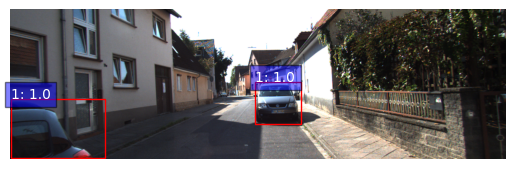

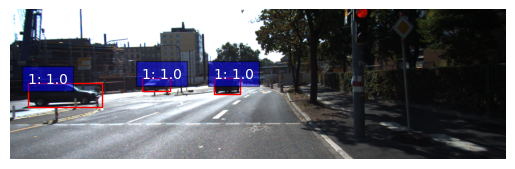

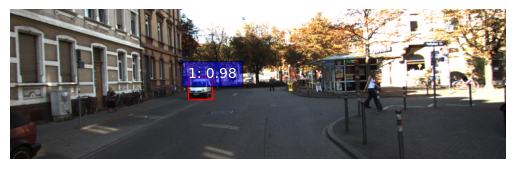

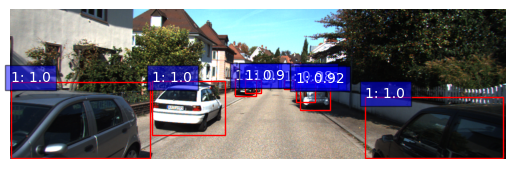

In [15]:
# Validation visualization
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

def visualize_prediction(image, prediction, threshold=0.9):
    image = image.permute(1, 2, 0).cpu().numpy()
    plt.imshow(image)

    boxes = prediction['boxes'].cpu().numpy()
    scores = prediction['scores'].cpu().numpy()
    labels = prediction['labels'].cpu().numpy()

    for box, score, label in zip(boxes, scores, labels):
        if score > threshold:
            x1, y1, x2, y2 = box
            plt.gca().add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1,
                                              fill=False, edgecolor='r', linewidth=1))
            plt.gca().text(x1, y1, f'{label}: {score:.2}', color='white',
                           bbox=dict(facecolor='blue', alpha=0.5))
    plt.axis('off')
    plt.show()

# Visualize a few examples
for images, _ in val_loader:
    with torch.no_grad():
        images_cuda = [img.to(device) for img in images]
        preds = model(images_cuda)
    for img, pred in zip(images, preds):
        visualize_prediction(img, pred)
    break  # remove break to visualize more


In [16]:
# Validation (Visualize & save)
import os
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

save_dir = '/content/result_faster_rcnn_conf_0.9'
os.makedirs(save_dir, exist_ok=True)

def visualize_and_save(image, prediction, idx, threshold=0.9):
    image_np = image.permute(1, 2, 0).cpu().numpy()
    plt.figure(figsize=(10,10))
    plt.imshow(image_np)

    boxes = prediction['boxes'].cpu().numpy()
    scores = prediction['scores'].cpu().numpy()
    labels = prediction['labels'].cpu().numpy()

    for box, score, label in zip(boxes, scores, labels):
        if score > threshold:
            x1, y1, x2, y2 = box
            plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                              fill=False, edgecolor='r', linewidth=2))
            plt.gca().text(x1, y1, f'{label}: {score:.2f}', color='white',
                           bbox=dict(facecolor='blue', alpha=0.5))

    plt.axis('off')
    save_path = os.path.join(save_dir, f'pred_{idx}.png')
    plt.savefig(save_path, bbox_inches='tight')
    plt.close()

# Run inference and save visualizations for the val_loader
idx = 0
model.eval()
with torch.no_grad():
    for images, _ in val_loader:
        images_cuda = [img.to(device) for img in images]
        preds = model(images_cuda)
        for img, pred in zip(images, preds):
            visualize_and_save(img, pred, idx)
            idx += 1

print(f"Saved {idx} prediction images to {save_dir}")


Saved 200 prediction images to /content/result_faster_rcnn_conf_0.9


In [17]:
from google.colab import files

# Zip the folder first
import shutil
shutil.make_archive('/content/result_faster_rcnn_conf_0.9', 'zip', '/content/result_faster_rcnn_conf_0.9')

# Download the zip file directly
files.download('/content/result_faster_rcnn_conf_0.9.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>